In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("Q2.csv", index_col=0)
df['y'] = df['y'].astype("category")
df.head(5)

,x1,x2,y
1,1.041478,2.294833,1
2,0.930416,-0.074211,1
3,-0.417394,-0.713259,0
4,1.448601,0.043548,0
5,0.867857,0.784432,1


In [3]:
z, y = np.split(df, [2], axis=1)
H = np.array([[.5, 0], [0, 0.5]])


# Question 1

In [4]:
def kernel(u, bandwidth): 
    return np.exp(-0.5 * (u / bandwidth)**2) / (np.sqrt(2 * np.pi) * bandwidth)

In [5]:
def multivariate_kde(data, bandwidth, kernel):
    if isinstance(data, pd.DataFrame):
        data = data.drop('y', axis=1)
        data = data.values
    
    def density(datapoints):
        if isinstance(datapoints, pd.DataFrame):
                datapoints = datapoints.values

        U = (datapoints[:, None, :] - data) @ np.linalg.inv(H)
        kernel_product = np.prod(kernel(U, 1), axis=2)
        weights = kernel_product / np.linalg.det(H)
        f = np.mean(kernel_product, axis=1) 
        return pd.Series(f)
    return density

def kdc(data: pd.DataFrame, bandwidth, kernel):
    gb = df.groupby('y', group_keys=False)
    pi = (gb.size()/len(df)).values
    
    def inner(datapoints):
        h = gb.apply(lambda x: multivariate_kde(x, bandwidth, kernel)(datapoints)).T.values
        h *= pi[None, :]
        h /= h.sum(axis=1)[:,None]
        return h

    return inner

m = kdc(df, H, kernel)

In [6]:
max_vals = df.max(axis=0, numeric_only=True)
min_vals = df.min(axis=0, numeric_only=True)
new_x, new_y = np.meshgrid(
    np.linspace(min_vals[0], max_vals[0], 100),
    np.linspace(min_vals[1], max_vals[1], 100)
)

datapoints = np.vstack([new_x.ravel(), new_y.ravel()]).T

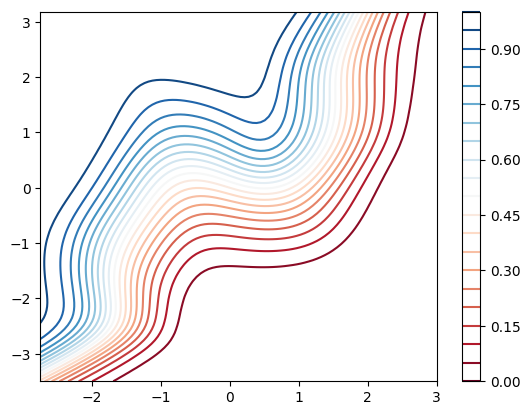

In [7]:
plt.contour(new_x, new_y, np.reshape(m(datapoints)[:,1], (100, 100)), 20, cmap='RdBu')
plt.colorbar()
plt.show()

# Question 2

In [8]:
def find_metrics(y_true, y_pred):
    true_positive = (y_true == 1) & (y_pred == 1)
    true_negative = (y_true == 0) & (y_pred == 0)
    false_positive = (y_true == 0) & (y_pred == 1)
    false_negative = (y_true == 1) & (y_pred == 0)
    return true_positive, true_negative, false_positive, false_negative

def pred(datapoints):
    return np.argmax(m(datapoints), axis=1)

In [9]:
y_pred = pred(df.drop('y', axis=1))
tp, tn, fp, fn = find_metrics(df['y'], y_pred)

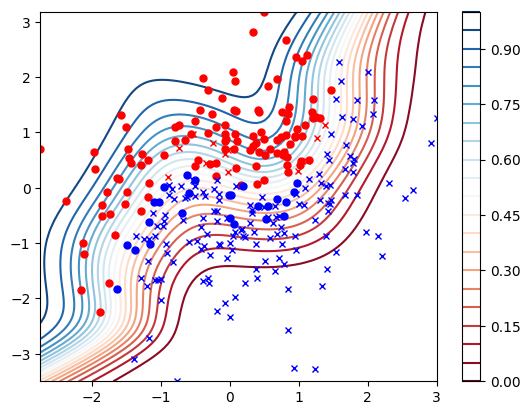

In [10]:
plt.contour(new_x, new_y, np.reshape(m(datapoints)[:,1], (100, 100)), 20, cmap='RdBu')
plt.colorbar()

plt.plot(df[tp]['x1'], df[tp]['x2'], 'or', ms=5)
plt.plot(df[tn]['x1'], df[tn]['x2'], 'xb', ms=5)

plt.plot(df[fp]['x1'], df[fp]['x2'], 'xr', ms=5)
plt.plot(df[fn]['x1'], df[fn]['x2'], 'ob', ms=5)
plt.show()

In [11]:
# univariate_gaussian_kde = lambda dataset: scipy.stats.gaussian_kde(dataset, bw_method=1)
# multiple_univariate_gaussian_kde = lambda dataset: dataset.apply(univariate_gaussian_kde)
# # multivariate_product_gaussian_kde = lambda dataset, datapoints: np.prod(pd.DataFrame([univariate_kde((datapoints).iloc[:, i]) for i, univariate_kde in enumerate(multiple_univariate_gaussian_kde(dataset))]), axis=0)

# def multivariate_product_gaussian_kde(dataset: pd.DataFrame, datapoints: pd.DataFrame, H=None):
#     H = np.identity(dataset.shape[1]) if H is None else H
#     dataset = dataset.copy()
#     for i, func in enumerate(multiple_univariate_gaussian_kde(dataset @ scipy.linalg.inv(H))):
#         dataset.iloc[:, i] = func(dataset.iloc[:, i])
#     return  1/scipy.linalg.det(H) * np.prod(dataset, axis=1)

# # multivariate_product_gaussian_kde = lambda dataset, datapoints, H=None: (
# #     1/scipy.linalg.det(np.identity(dataset.shape[1]) if H is None else H) * 
# #     np.prod(pd.DataFrame([func(dataset.iloc[:, i]) for i, func in enumerate(
# #         multiple_univariate_gaussian_kde(datapoints @ scipy.linalg.inv(np.identity(dataset.shape[1]) if H is None else H))
# #         )]), axis=0)
# # )

# multivariate_product_gaussian_kde(z, z, H)


In [12]:
# def f(dataset, datapoints, H=None):
#     gb = dataset.groupby('y', group_keys=False)
#     ans = gb.apply(lambda filtered_dataset: multivariate_product_gaussian_kde(filtered_dataset[filtered_dataset.columns.difference(['y'])], datapoints, H))
#     return ans

# ans = f(df, x, H)

# ans
# gb = df.groupby('y', group_keys=False)
# lambda filtered_dataset: multivariate_product_gaussian_kde(filtered_dataset[filtered_dataset.columns.difference(['y'])], x, H)
# gb.apply(lambda filtered_dataset: multivariate_product_gaussian_kde(filtered_dataset[filtered_dataset.columns.difference(['y'])], x, H))

In [13]:
# def kernel(u, bandwidth): 
#     return np.exp(-0.5 * (u / bandwidth)**2) / (np.sqrt(2 * np.pi) * bandwidth)


# def univariate_gaussian_kde(data, bandwidth):
#     """
#     Computes a univariate Gaussian kernel density estimation.
#     data : array-like, shape (n_samples,)
#         Input data.
#     bandwidth : float
#         Bandwidth for the kernel.
#     Returns
#     -------
#     kde : callable
#         The estimated density function.
#     """
#     if isinstance(data, pd.DataFrame):
#         data = data.values.flatten()

#     n_samples = data.shape[0]
#     def density(x):
#         if isinstance(x, pd.DataFrame):
#             x = x.values.flatten()
#         result = 0
#         for datapoint in data:
#             result += kernel(x - datapoint, bandwidth)
#         return result / n_samples
#     return density

# def multivariate_gaussian_kde(data, bandwidth):
#     """
#     Computes a multivariate Gaussian kernel density estimation.
#     data : array-like, shape (n_samples, n_features)
#         Input data.
#     bandwidth : array-like, shape (n_features, n_features)
#         Bandwidth matrix for the kernel.
#     Returns
#     -------
#     kde : callable
#         The estimated density function.
#     """
#     if isinstance(data, pd.DataFrame):
#         data = data.values
#     n_samples, n_features = data.shape
#     det = np.linalg.det(bandwidth)
#     inv_bandwidth = np.linalg.inv(bandwidth)
    
#     def density(x):
#         if isinstance(x, pd.DataFrame):
#             x = x.values
#         end_result = 0
            
            
#         for i in range(n_samples):
#             mid_result = 1
#             U = (x - data[i, :]) @ inv_bandwidth

#             for j in range(n_features):
#                 mid_result *= kernel(U[:, j], 1)
#             end_result += mid_result
#         return pd.Series(end_result / (n_samples * det))
#     return density


In [14]:
# gb = df.groupby('y', group_keys=False)
# pi = gb.size()/len(df)
# H = np.array([[.5, 0], [0, 0.5]])

In [15]:
# max_vals = df.max(axis=0, numeric_only=True)
# min_vals = df.min(axis=0, numeric_only=True)
# new_x, new_y = np.meshgrid(
#     np.linspace(min_vals[0], max_vals[0], 100),
#     np.linspace(min_vals[1], max_vals[1], 100)
# )

# datapoints = np.vstack([new_x.ravel(), new_y.ravel()]).T
# f = gb.apply(lambda df: multivariate_gaussian_kde(df[df.columns.difference(['y'])], H)(datapoints))

# F = (f.T * pi).values
# F /= F.sum(axis=1)[:,None]
# F

In [16]:
# z, y = np.split(df, [2], axis=1)
# f = gb.apply(lambda df: multivariate_gaussian_kde(df[df.columns.difference(['y'])], H)(z))
# G = (f.T * pi).values
# G /= G.sum(axis=1)[:,None]
# data = np.concatenate((z, y), axis=1)
# true_neg = data[np.logical_and(data[:,2]==0, G[:,0]>0.5)]
# true_pos = data[np.logical_and(data[:,2]==1, G[:,0]<=0.5)]
# false_neg = data[np.logical_and(data[:,2]==1, G[:,0]>0.5)]
# false_pos = data[np.logical_and(data[:,2]==0, G[:,0]<=0.5)]

# missclassificationss = false_neg.shape[0] + false_pos.shape[0]

In [17]:
# max_vals = df.max(axis=0, numeric_only=True)
# min_vals = df.min(axis=0, numeric_only=True)
# new_x, new_y = np.meshgrid(
#     np.linspace(min_vals[0], max_vals[0], 100),
#     np.linspace(min_vals[1], max_vals[1], 100)
# )

# datapoints = np.vstack([new_x.ravel(), new_y.ravel()]).T
# f = gb.apply(lambda df: multivariate_gaussian_kde(df[df.columns.difference(['y'])], H)(datapoints))

# F = (f.T * pi).values
# F /= F.sum(axis=1)[:,None]
# F

In [18]:
# plt.contour(new_x, new_y, np.reshape(F[:,0], (100, 100)), 20, cmap='RdBu')
# plt.colorbar()

# plt.plot(true_pos[:,0], true_pos[:,1], 'or', ms=5)
# plt.plot(true_neg[:,0], true_neg[:,1], 'xb', ms=5)

# plt.plot(false_pos[:,0], false_pos[:,1], 'xr', ms=5)
# plt.plot(false_neg[:,0], false_neg[:,1], 'ob', ms=5)
# plt.show()

In [19]:
# z.shape
# datapoints = np.vstack([new_x.ravel(), new_y.ravel()]).T

# U = datapoints[:, None, :] - z.values
# U = U @ np.linalg.inv(H)
# U


# f = np.mean(np.prod(kernel(U, 1), axis=2), axis=1) / np.linalg.det(H)
# f.shape
# # F = (f.T * pi).values
# # F /= F.sum(axis=1)[:,None]
# gb = df.groupby('y', group_keys=False)
# pi = (gb.size()/len(df)).values

# def f(x, datapoints, H):
#     z, y = np.split(x, [2], axis=1)
#     U = datapoints[:, None, :] - z.values
#     U = U @ np.linalg.inv(H)
#     ans = pd.Series(np.mean(np.prod(kernel(U, 1), axis=2), axis=1) / np.linalg.det(H))
#     return ans

# h = gb.apply(lambda x: f(x, datapoints, H)).T.values
# h *= pi[None, :]
# h /= h.sum(axis=1)[:,None]
# h
